
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes. Cada uno de los metodos se realizan en maquinas distintas. Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación.  Si los tiempos de fabricacion son negativos significara que las maquinas estuvieron paradas esos minutos. 



1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [117]:
df_1 = pd.read_csv('datos/linea_montaje.csv')
df_1.head()

,minutos,metodo
0,4.166484,A
1,4.887466,A
2,0.727608,A
3,8.280542,A
4,1.413129,A


In [118]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
minutos,150.0,4.895103,2.222707,-0.818899,3.528356,4.870153,6.328776,12.059491


In [119]:
df_1[df_1['minutos'] < 0]

,minutos,metodo
76,-0.818899,B
99,-0.187206,B


Vemos que el valor mínimo de los minutos es negativo, lo cual es imposible. Como cuentan como tiempo de máquina parada los dejamos así, ya que afectan al promedio de tiempo que tarda la máquina.

In [120]:
df_promedios = df_1.groupby('metodo')['minutos'].mean().reset_index()
df_promedios

,metodo,minutos
0,A,4.720512
1,B,4.364523
2,C,5.600274


/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_57312/1100277741.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'metodo', y = 'minutos', data = df_promedios, palette='mako')


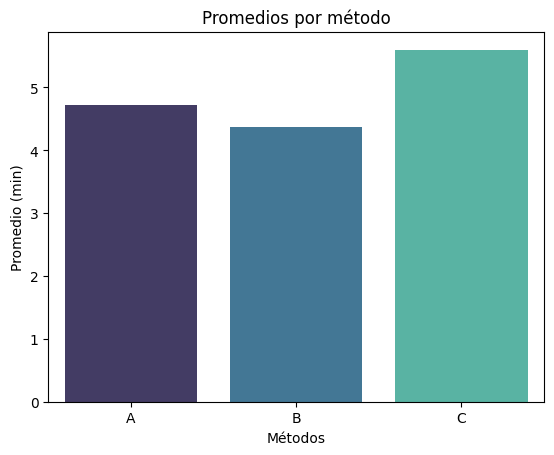

In [121]:
plt.figure()

sns.barplot(x = 'metodo', y = 'minutos', data = df_promedios, palette='mako')
plt.title('Promedios por método')
plt.xlabel('Métodos')
plt.ylabel('Promedio (min)')
plt.show()

In [122]:
# Construimos los dataframes para cada método
df_a = df_1[df_1['metodo'] == 'A']
df_b = df_1[df_1['metodo'] == 'B']
df_c = df_1[df_1['metodo'] == 'C']

In [123]:
print(f"Tamaño de los dataframes:\nA: {df_a.shape[0]}\nB: {df_b.shape[0]}\nC: {df_c.shape[0]}")

Tamaño de los dataframes:
A: 50
B: 50
C: 50


Como los tamaños son > 30, utilizaremos el test de Kormogolov para comprobar la normalidad

In [124]:
def normalidad_ks(df):

    data_mean = df.mean()
    data_std = df.std()
    
    return stats.kstest(df, 'norm', args=(data_mean, data_std))

In [125]:
print(f"El valor de p es:\nA: {normalidad_ks(df_a['minutos'])[1]}\nB: {normalidad_ks(df_b['minutos'])[1]}\nC: {normalidad_ks(df_c['minutos'])[1]}")

El valor de p es:
A: 0.831915919566997
B: 0.5135125149364379
C: 0.6354526500316278


Todos los valores de p son superiores a 0.05 (o cualquier valor típico de $\alpha$), por lo que todas son distribuciones normales

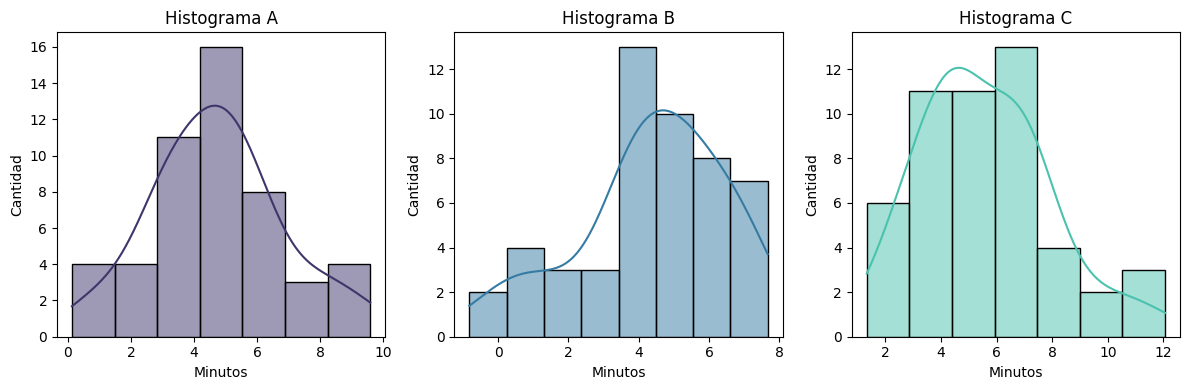

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

dfs = [df_a, df_b, df_c]
letters = ['A', 'B', 'C']
mako_colors = sns.color_palette("mako", 3)

for i, df in enumerate(dfs):
    sns.histplot(df['minutos'], kde=True, ax=axes[i], color=mako_colors[i], element="bars")
    axes[i].set_title(f'Histograma {letters[i]}')
    axes[i].set_xlabel('Minutos')
    axes[i].set_ylabel('Cantidad')

fig.tight_layout()
plt.show()

Calculamos la asimetría para comprobarlo numéricamente

In [127]:
print(f"La asimetría es:\nA: {df_a['minutos'].skew().round(2)}\nB: {df_b['minutos'].skew().round(2)}\nC: {df_c['minutos'].skew().round(2)}")

La asimetría es:
A: 0.25
B: -0.68
C: 0.61


Como hay alguna distribución asimétrica usamos el test de Levene

In [128]:
print(f'El valor de p del test de Levene es {stats.levene(df_a['minutos'], df_b['minutos'], df_c['minutos'])[1].round(4)}')

El valor de p del test de Levene es 0.6003


Como el valor de p es mayor que 0.05 (y cualquier valor típico de $\alpha$), no se puede rechazar la hipótesis de que las varianzas son iguales. De esta forma podemos hacer el contraste de hipótesis con métodos paramétricos.

Como tenemos 3 grupos usaremos el test ANOVA

In [129]:
print(f'El valor de p del test ANOVA {stats.f_oneway(df_a['minutos'], df_b['minutos'], df_c['minutos'])[1].round(4)}')

El valor de p del test ANOVA 0.0157


Como el valor de p es menor que 0.05, rechazamos la hipótesis de que todos los métodos tardan lo mismo, es decir, al menos alguno de ellos es distinto.

En vista del gráfico de barras inicial, A y B parecen ser lo más óptimos por lo que comprobemos si son significativamente diferentes entre sí

In [130]:
print(f'El valor de p del t-test {stats.ttest_ind(df_a['minutos'], df_b['minutos'], equal_var=True, alternative='two-sided')[1].round(4)}')

El valor de p del t-test 0.3974


Como el valor de p es mayor a 0.05 no hay evidencia estadística que nos indique que tardan un tiempo diferente, por lo que nos podríamos quedar con cualquiera de los métodos A o B

---

#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

In [131]:
df_2 = pd.read_csv('datos/densidad_fluidos.csv')
df_2.head()

,temperatura,densidad
0,100,21.790655
1,100,21.725900
2,100,21.806052
3,100,21.895319
4,100,21.716121


In [132]:
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
temperatura,400.0,137.500000,27.985854,100.000000,118.75000,137.500000,156.250000,175.000000
densidad,400.0,21.733028,0.169214,21.323342,21.61463,21.742521,21.843457,22.170432


In [133]:
# Veamos los diferentes valores que tenemos de temperatura
df_2['temperatura'].unique()

array([100, 125, 150, 175])

Vemos que solamente tenemos 4 valores diferentes. Veamos cómo nos queda el promedio por cada temperatura

In [134]:
df_promedios = df_2.groupby('temperatura')['densidad'].mean().reset_index()
df_promedios

,temperatura,densidad
0,100,21.729410
1,125,21.532402
2,150,21.766618
3,175,21.903682


In [135]:
df_promedios['densidad'].min()

21.532402277544378

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_57312/3511242506.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'temperatura', y = 'densidad', data = df_promedios, palette='mako')


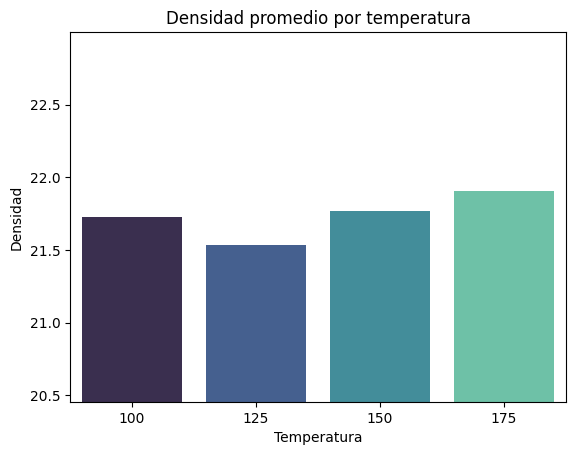

In [136]:
plt.figure()

sns.barplot(x = 'temperatura', y = 'densidad', data = df_promedios, palette='mako')
plt.title('Densidad promedio por temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Densidad')
plt.ylim(df_promedios['densidad'].min() * 0.95, df_promedios['densidad'].max() * 1.05)
plt.show()

In [137]:
# Construimos los dataframes para cada temperatura
lista_df = [df_2[df_2['temperatura'] == temp] for temp in df_2['temperatura'].unique()]

In [138]:
for df in lista_df:
    print(f"El tamaño del dataframe es {df.shape[0]}")

El tamaño del dataframe es 100
El tamaño del dataframe es 100
El tamaño del dataframe es 100
El tamaño del dataframe es 100


Vemos que el tamaño de todos los dataframes es 100 por lo que utilizaremos el test de Kormogolov para comprobar la normalidad

In [ ]:
for df in lista_df:
    print(f"El valor de p es {normalidad_ks(df['densidad'])[1].round(3)}")

El valor de p es 0.939
El valor de p es 0.649
El valor de p es 0.9
El valor de p es 0.931


Todos los valores de p son superiores a 0.05 (o cualquier valor típico de $\alpha$), por lo que todas son distribuciones normales

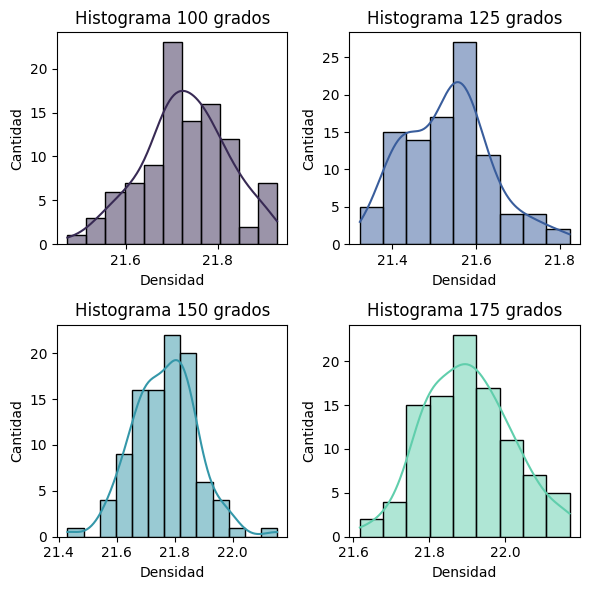

In [148]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
axes = axes.flat

mako_colors = sns.color_palette("mako", 4)

for i, df in enumerate(lista_df):
    sns.histplot(df['densidad'], kde=True, ax=axes[i], color=mako_colors[i], element="bars")
    axes[i].set_title(f'Histograma {df_2['temperatura'].unique()[i]} grados')
    axes[i].set_xlabel('Densidad')
    axes[i].set_ylabel('Cantidad')

fig.tight_layout()
plt.show()

In [151]:
for df in lista_df:
    print(f"La asimetría {df['densidad'].skew().round(2)}")

La asimetría -0.18
La asimetría 0.39
La asimetría 0.18
La asimetría 0.2


Como hay alguna distribución asimétrica usamos el test de Levene

In [157]:
lista_df_densidad = [df['densidad'] for df in lista_df]

print(f'El valor de p del test de Levene es {stats.levene(*lista_df_densidad)[1].round(3)}')

El valor de p del test de Levene es 0.253


Como el valor de p es mayor que 0.05 (y cualquier valor típico de $\alpha$), no se puede rechazar la hipótesis de que las varianzas son iguales. De esta forma podemos hacer el contraste de hipótesis con métodos paramétricos.

Como tenemos 4 grupos usaremos el test ANOVA

In [160]:
print(f'El valor de p del test ANOVA {stats.f_oneway(*lista_df_densidad)[1]}')

El valor de p del test ANOVA 3.327798065118271e-82


Como el valor de p es menor que 0.05, rechazamos la hipótesis de que la densidad no es significativamente afectada por la temperatura, por lo que la temperatura SÍ afecta notablemente a la densidad

Comprobemos ahora si las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175

In [166]:
# Agrupamos los datos en los dos grupos
df_temp_baja = df_2[df_2['temperatura'].between(100, 125, inclusive='both')]['densidad']
df_temp_alta = df_2[df_2['temperatura'].between(150, 175, inclusive='both')]['densidad']

In [172]:
print(f'El valor de p del t-test {stats.ttest_ind(df_temp_baja, df_temp_alta, equal_var=True, alternative='less')[1]}')

El valor de p del t-test 1.7819248174619983e-41


Como el valor de p es menor que 0.05, rechazamos la hipótesis de que la densidad no es significativamente menor en el primer grupo, por lo que las temperaturas 100 y 125 SÍ provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175.

---
